In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create a phonebook

A phonebook maps clusters to partitions under the following constraints.

1. All clusters in the same bucket MUST go in the same partition.
2. A partition CANNOT contain clusters totalling more than N records.
3. Clusters that are similar to each other SHOULD go in the same partition.

## Aproach

1. Choose a maximum number of partitions and a maximum number of records per partition.
2. Compute the top N most-similar clusters to each cluster.
3. Start by putting the clusters for each bucket in their own partition.
4. Some buckets because of their size will span multiple partitions. Split those buckets up-front.
5. While there are more than the maximum number of partitions, merge partitions containing the most-similar (to least-similar) clusters so long as the combined partition doesn't exceed the maximum partition size.
6. If you end up with too many partitions, or many partitions that have significantly fewer number of records than the maximum, consider repeating the steps with a lower maximum number of records per partition.

In [2]:
from collections import defaultdict
import json
import re

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from nama.data.filesystem import download_file_from_s3, save_file
from nama.data.utils import read_csv
from nama.models.utils import top_similar_names

In [7]:
# configure
# run only for surname
given_surname = "surname"

phonebook_type = 'hr'  # 'tree'
pref_prefix = 'hr' if phonebook_type == 'hr' else 'tree-preferred'
n_partitions = 720
max_partition_size = 15_800_000 if phonebook_type == 'hr' else 1_250_000
min_threshold = 0.6

linkage = "average"
similarity_threshold = 0.1 if given_surname == "given" else 0.25
cluster_freq_normalizer = "none"
clusters_path = f"s3://fs-nama-data/2024/nama-data/data/processed/clusters_{given_surname}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}-augmented.json"
super_clusters_path = f"s3://fs-nama-data/2024/nama-data/data/processed/super_clusters_{given_surname}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}.json"
pref_path = f"s3://fs-nama-data/2024/familysearch-names/processed/tree-preferred-{given_surname}-aggr.csv.gz"

phonebook_path = f"s3://fs-nama-data/2024/familysearch-names/processed/{phonebook_type}-phonebook.json"

### Load data

In [8]:
# dict of name -> freq
path = download_file_from_s3(pref_path) if pref_path.startswith("s3://") else pref_path
pref_df = read_csv(path)
name_freq = {name: freq for name, freq in zip(pref_df['name'], pref_df['frequency']) \
                if re.fullmatch(r'[a-z]+', name)}
pref_df = None

In [9]:
print(len(name_freq))
print(sum(list(name_freq.values())))

2691517
1607582733


In [11]:
# load clusters and super-clusters
name_cluster = {}       # name -> cluster position
cluster_centroids = []  # centroid for each cluster
cluster_labels = []     # label for each cluster
cluster_indexes = {}    # cluster label -> index
cluster_sizes = []      # number of records for each cluster

path = download_file_from_s3(clusters_path) if clusters_path.startswith("s3://") else clusters_path
with open(path, 'r') as f:
    clusters = json.load(f)  # cluster label -> names, centroid

path = download_file_from_s3(super_clusters_path) if super_clusters_path.startswith("s3://") else super_clusters_path
with open(path, 'r') as f:
    super_clusters = json.load(f)  # super_cluster label -> cluster labels

for label, cluster in clusters.items():
    n_records = 0
    for name in cluster['names']:
        name_cluster[name] = len(cluster_labels)
        n_records += name_freq.get(name, 0)
    cluster_indexes[label] = len(cluster_labels)
    cluster_labels.append(label)
    cluster_sizes.append(n_records)
    cluster_centroids.append(np.array(cluster['centroid']))
cluster_labels = np.array(cluster_labels)

In [12]:
print('number of names', len(name_cluster))
print('number of clusters', len(cluster_labels))
print('number of super-clusters', len(super_clusters))

number of names 154032
number of clusters 16233
number of super-clusters 2556


In [13]:
print('size of all clusters', sum(cluster_sizes))

size of all clusters 1537330250


In [14]:
print('perfect partition size', sum(cluster_sizes) / n_partitions)

perfect partition size 2135180.902777778


## Compute nearby clusters

In [15]:
%%time
cluster_similarity_scores = []  # [(ix1, ix2, similarity)]
top_n = 1000
for ix, centroid in tqdm(enumerate(cluster_centroids), mininterval=2.0):
    nearby_clusters, similarities = top_similar_names(centroid, cluster_centroids, cluster_labels,
                                                      threshold=min_threshold, top_n=top_n)
    for nearby_cluster, similarity in zip(nearby_clusters, similarities):
        nearby_ix = cluster_indexes[nearby_cluster]
        if ix >= nearby_ix:
            continue
        cluster_similarity_scores.append((ix, nearby_ix, similarity))

0it [00:00, ?it/s]

In [16]:
cluster_similarity_scores = sorted(cluster_similarity_scores, key=lambda x: x[2], reverse=True)

In [17]:
len(cluster_similarity_scores)

159150

## Create phonebook

In [30]:
def merge_partitions(ix1, ix2):
    global partition_ix, partition_clusters, partition_size, cluster_partitions

    # remove old partitions from cluster_partitions
    for cluster in partition_clusters[ix1]:
        cluster_partitions[cluster].remove(ix1)
    for cluster in partition_clusters[ix2]:
        cluster_partitions[cluster].remove(ix2)
    # add clusters to new partition
    partition_clusters[partition_ix] = partition_clusters[ix1] + partition_clusters[ix2]
    for cluster in partition_clusters[partition_ix]:
        cluster_partitions[cluster].append(partition_ix)    
    # calc size of new partition
    partition_size[partition_ix] = partition_size[ix1] + partition_size[ix2]
    # delete old partitions
    del partition_clusters[ix1]
    del partition_clusters[ix2]
    del partition_size[ix1]
    del partition_size[ix2]
    # update next available partition index
    partition_ix += 1

### Start by creating partitions for each cluster

In [31]:
partition_ix = 0
partition_clusters = {}                # partition -> [cluster ix]
partition_size = {}                    # partition -> size
cluster_partitions = defaultdict(list) # cluster -> [partition ix]

In [32]:
for ix in range(len(cluster_labels)):
    # calculate the number of partitions needed for the cluster
    size = cluster_sizes[ix]
    n_cluster_partitions = 1
    while size > max_partition_size:
        print(size, cluster_labels[ix])
        n_cluster_partitions += 1
        size -= max_partition_size
    # assign cluster to n_cluster_partitions
    for _ in range(n_cluster_partitions):
        partition_clusters[partition_ix] = [ix]
        cluster_partitions[ix].append(partition_ix)
        partition_size[partition_ix] = cluster_sizes[ix] / n_cluster_partitions
        partition_ix += 1

29740531 annette/anna
16174715 antonio/antonio
22372661 catherine/catharina
30103447 elizabeth/elizabeth
24800265 frank/francisco
16883283 george/george
17196428 james/james
38677759 john/john
22877759 john/john
20213930 john/johann
27671403 joseph/joseph
20530756 joseph/jose
18841564 margaret/margaret
93376120 mary/maria
77576120 mary/maria
61776120 mary/maria
45976120 mary/maria
30176120 mary/maria
33048968 mary/mary
17248968 mary/mary
18969606 thomas/thomas
30905645 william/william


In [33]:
partition_ix

16255

## Review single-character names

In [34]:
total_freq = 0
for name, freq in name_freq.items():
    if len(name) > 1:
        continue
    print(name, freq)
    total_freq += freq
print(total_freq)

a 6615822
m 6554747
j 5977694
l 4133834
c 3863195
h 3704733
w 3588789
b 2867914
f 2659581
r 2352188
s 2153925
d 1911997
g 1858226
t 1475387
p 1475199
n 984389
v 808752
k 645155
i 644368
u 155034
x 69683
z 65835
q 30871
54597318


### Merge clusters for the same super-cluster

In [35]:
def get_smallest_partition(ixs):
    size = None
    smallest_ix = None
    for ix in ixs:
        if size is None or size > partition_size[ix]:
            size = partition_size[ix]
            smallest_ix = ix
    return ix

In [36]:
for super_cluster in super_clusters.values():
    first_cluster_label = super_cluster[0]
    for cluster_label in super_cluster[1:]:
        ix1s = cluster_partitions[cluster_indexes[first_cluster_label]]
        ix2s = cluster_partitions[cluster_indexes[cluster_label]]
        # if both clusters span multiple partions, don't try to merge
        if len(ix1s) > 1 and len(ix2s) > 1:
            continue
        # if clusters are already on same partition, don't need to merge
        if (len(ix1s) == 1 and ix1s[0] in ix2s) or (len(ix2s) == 1 and ix2s[0] in ix1s):
            continue
        # merge the smallest partition if > 1 partition
        ix1 = get_smallest_partition(ix1s) if len(ix1s) > 1 else ix1s[0]
        ix2 = get_smallest_partition(ix2s) if len(ix2s) > 1 else ix2s[0]
        if partition_size[ix1] + partition_size[ix2] <= max_partition_size:
            merge_partitions(ix1, ix2)

In [37]:
len(partition_clusters)

9709

### Merge partitions containing most-similar clusters

In [38]:
for cix1, cix2, _ in tqdm(cluster_similarity_scores, mininterval=2.0):
    if len(partition_clusters) <= n_partitions:
        break
    pix1s = cluster_partitions[cix1]
    pix2s = cluster_partitions[cix2]
    # if both clusters span multiple partions, don't try to merge
    if len(pix1s) > 1 and len(pix2s) > 1:
        continue
    # if clusters are already on same partition, don't need to merge
    if (len(pix1s) == 1 and pix1s[0] in pix2s) or (len(pix2s) == 1 and pix2s[0] in pix1s):
        continue
    # merge the smallest partition if > 1 partition
    pix1 = get_smallest_partition(pix1s) if len(pix1s) > 1 else pix1s[0]
    pix2 = get_smallest_partition(pix2s) if len(pix2s) > 1 else pix2s[0]
    if partition_size[pix1] + partition_size[pix2] <= max_partition_size:
        merge_partitions(pix1, pix2)    

  0%|          | 0/159150 [00:00<?, ?it/s]

In [39]:
len(partition_clusters)

1175

### Merge other partitions using best-fit

In [40]:
while len(partition_clusters) > n_partitions:
    # find the smallest partition
    small_ix = min(partition_size, key=partition_size.get)
    # find the largest (or first?) partition it will fit into
    large_ix = None
    for pix, size in partition_size.items():
        if pix == small_ix or partition_size[small_ix] + size > max_partition_size:
            continue
        if large_ix is None or size > partition_size[large_ix]:
            large_ix = pix
    if large_ix is None:
        break
    # merge them
    merge_partitions(small_ix, large_ix)

## Check number of partitions

In [41]:
if len(partition_clusters) > n_partitions:
    print('We have a problem!')
len(partition_clusters)

720

## Add single-character surnames to partitions

Don't update partition_clusters because we don't use it from here on. 

Instead, add single-character surnames to cluster_labels and cluster_partitions, and update partition_size.

In [42]:
single_character_name_freq = {name: freq for name, freq in name_freq.items() if len(name) == 1}
len(single_character_name_freq)

23

In [43]:
cluster_labels_list = cluster_labels.tolist()
len(cluster_labels_list)

16233

In [44]:
for name, freq in sorted(single_character_name_freq.items(), key=lambda kv: kv[1], reverse=True):
    cix = len(cluster_labels_list)
    # add name to cluster_labels
    cluster_labels_list.append(name)
    # find the smallest partition
    small_ix = min(partition_size, key=partition_size.get)
    # add the name to that partition
    cluster_partitions[cix] = [small_ix]
    partition_size[small_ix] += freq 
    print(f"added {name} with freq {freq} to partition {small_ix}; new size is {partition_size[small_ix]}")
    if partition_size[small_ix] > max_partition_size:
        print('WARNING: oversized partition', ix, partition_size[small_ix])

added a with freq 6615822 to partition 4566; new size is 6616688.0
added m with freq 6554747 to partition 30756; new size is 6555617.0
added j with freq 5977694 to partition 15585; new size is 5978569.0
added l with freq 4133834 to partition 11543; new size is 4134719.0
added c with freq 3863195 to partition 8347; new size is 3864083.0
added h with freq 3704733 to partition 15695; new size is 3705621.0
added w with freq 3588789 to partition 15645; new size is 3589681.0
added b with freq 2867914 to partition 1011; new size is 2868807.0
added f with freq 2659581 to partition 2008; new size is 2660480.0
added r with freq 2352188 to partition 4441; new size is 2353092.0
added s with freq 2153925 to partition 15652; new size is 2154833.0
added d with freq 1911997 to partition 1762; new size is 1912908.0
added g with freq 1858226 to partition 9694; new size is 1859140.0
added t with freq 1475387 to partition 7703; new size is 1476302.0
added p with freq 1475199 to partition 15642; new size i

In [45]:
cluster_labels = np.array(cluster_labels_list)

### Check partition sizes

In [46]:
# count number of partitions that are less than 90% full, 75% full, half full
for threshold in [0.90, 0.75, 0.5, 0.25]:
    print(threshold, len([size for size in partition_size.values() if size < max_partition_size * threshold]))

0.9 637
0.75 631
0.5 619
0.25 612


## Plot partition sizes

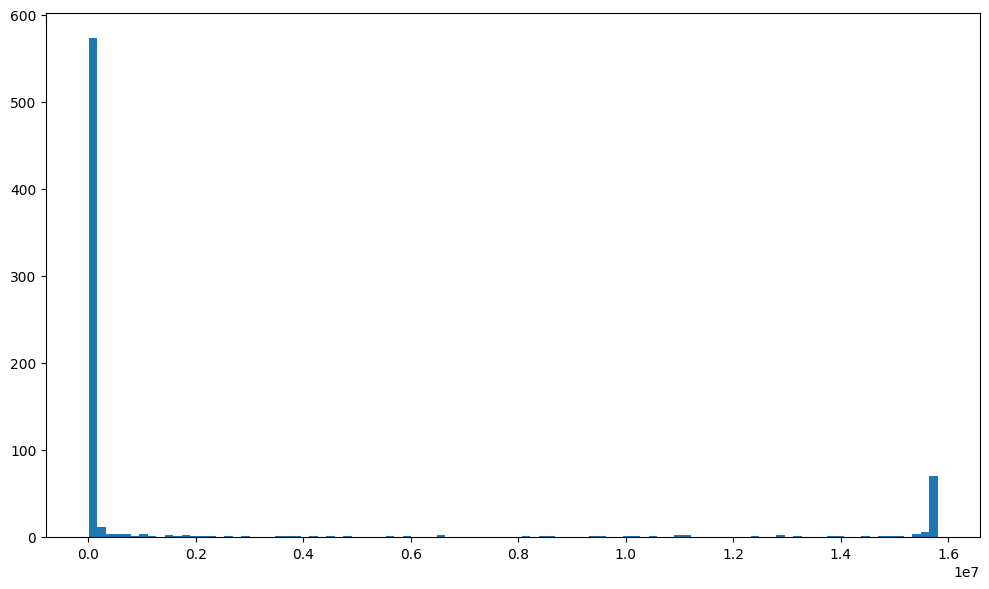

In [47]:
plt.figure(figsize=(10, 6))
plt.hist(partition_size.values(), bins=100)
plt.tight_layout()
plt.show()

## Plot scores

In [48]:
same_partition_scores = []
diff_partition_scores = []
for cix1, cix2, score in cluster_similarity_scores:
    if cix1 == cix2:
        continue
    pix1s = cluster_partitions[cix1]
    pix2s = cluster_partitions[cix2]
    if (len(pix1s) == 1 and pix1s[0] in pix2s) or (len(pix2s) == 1 and pix2s[0] in pix1s):
        same_partition_scores.append(score)
    else:
        diff_partition_scores.append(score)
print(len(same_partition_scores))
print(len(diff_partition_scores))

50066
109084


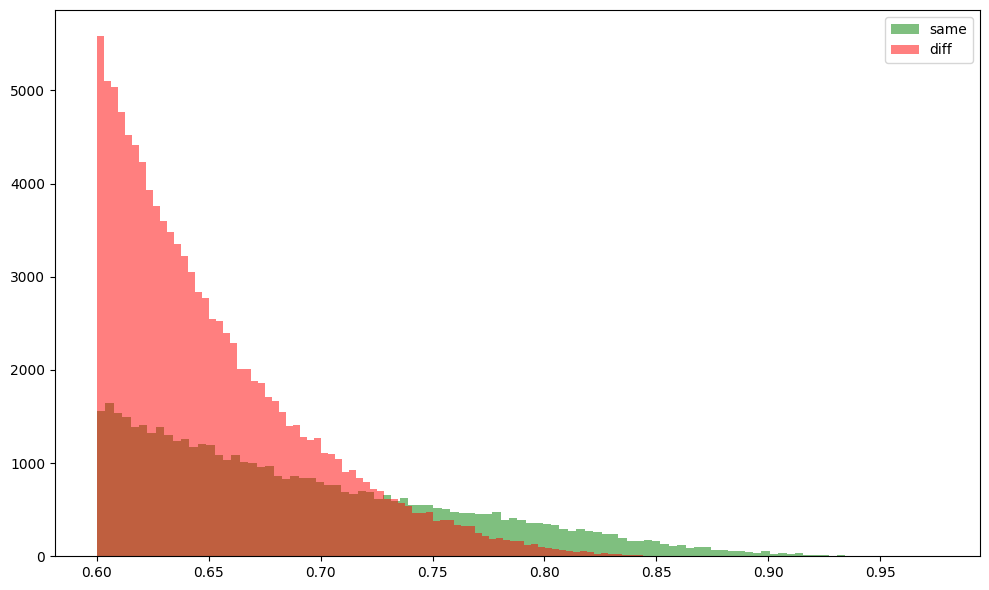

In [49]:
plt.figure(figsize=(10, 6))
plt.hist(same_partition_scores, bins=100, alpha=0.5, label="same", color='green')
plt.hist(diff_partition_scores, bins=100, alpha=0.5, label="diff", color='red')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Save phonebook

In [50]:
final_partition_start = 0
cluster_final_partition = defaultdict(list)
partition2final_partition = {}
# renumber partition ids to start at 0
for cix, partitions in cluster_partitions.items():
    cluster_id = cluster_labels[cix]
    for partition in partitions:
        if partition in partition2final_partition:
            final_partition = partition2final_partition[partition]
        else:
            final_partition = final_partition_start
            partition2final_partition[partition] = final_partition_start
            final_partition_start += 1
        cluster_final_partition[cluster_id].append(final_partition)

In [51]:
# should be 720
final_partition_start

720

In [87]:
save_file(phonebook_path,
          lambda local_out_path : json.dump(cluster_final_partition, open(local_out_path, 'w')))

In [52]:
phonebook_path

's3://fs-nama-data/2024/familysearch-names/processed/hr-phonebook.json'

In [53]:
cluster_final_partition['a']

[270]